# Applied Data Science Homework #3
_**Use of SageMaker to connect to data, explore data and build models**_

---

---
## Contents

1. [Data](#Data)
  1. [Load](#Load)
  2. [Explore](#Explore)
  3. [Transformation](#Transform-Data)
2. [Training](#Training)
3. [Hosting](#Hosting)
4. [Evaluation](#Evaluation)
5. [Summary](#Summary)


## Background
ACME has provided you with a daily set of parameters for their devices. There is also a column, "failure", that indicates whether or not the device has failed. The goal is to use the data to develop a model to predict failure of the devices that minimizes both false positives and false negatives.


### What is the big deal about separating storage and compute?
Q: What happens if I give all of you access to the same on-site DB/hadoop cluster and each of you has the same tight deadline for a analytic/ML heavy job?
A: The server/servers would not be able to handle the compute load.

### Ways to Query S3 Data:
* SageMaker - Amazon SageMaker is a fully-managed platform that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. Amazon SageMaker removes all the barriers that typically slow down developers who want to use machine learning. https://aws.amazon.com/sagemaker/ 
* QuickSight - Amazon QuickSight is a fast, cloud-powered BI service that makes it easy to build visualizations, perform ad-hoc analysis, and quickly get business insights from your data. Using our cloud-based service you can easily connect to your data, perform advanced analysis, and create stunning visualizations and rich dashboards that can be accessed from any browser or mobile device. https://aws.amazon.com/quicksight/
* Redshift - via Spectrum Query https://docs.aws.amazon.com/redshift/latest/dg/c-getting-started-using-spectrum-query-s3-data.html
* Athena - serverless query service


## Preparation
Prior to moving on to exploration in the notebook need to install a few packages that will be used to connect to the data. You only need to run the installation cell once. If you move the notebook file to another SageMaker instance, you would need to run the cell again to ensure the packages are installed on your virtual machine (EC2 powering SageMaker).

After the install, we load packages to support our anticipated work.

In [1]:
# install packages needed for db interface (uncomment lines 2 and 3 for first run)
!conda install -y -c anaconda psycopg2
!conda install mysql-connector-python -y
get_ipython().system('pip install xgboost')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - psycopg2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py36_1         140 KB  anaconda
    numpy-base-1.14.3          |   py36h9be14a7_1         4.1 MB  anaconda
    psycopg2-2.7.5             |   py36hb7f436b_0         294 KB  anaconda
    numpy-1.14.3               |   py36hcd700cb_1          41 KB  anaconda
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    scikit-learn-0.19.1        |   py36h7aa7ec6_0         5.2 MB  anaconda
    scipy-1.1.0                |   py36hfc37229_0        18.1 MB  anaconda
    ope

In [4]:
# load packages 
import os
import numpy as np
import boto3
import io
import pandas as pd
import json
import psycopg2
import sqlalchemy as sa
import mysql.connector
import seaborn as sns
sns.set(style='white', color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
import scipy
import time
from datetime import date
from collections import OrderedDict
pd.options.display.max_rows = 1000
RANDOM_STATE=0


# get the region (pay attention to the region of your S3, SageMaker ... keep them in same region where possible)
region = boto3.Session().region_name

## Data
You should have 11 months worth of data with a column for date, device, failure and 9 different attribute readings.

### Load
S3 is the preferred location for data when working with SageMaker, as it is foundational to seperating storage and compute (a key advantage of AWS).

In this notebook, we will look at loading the data from S3

Ultimately the goal is to get the data in the familiar pandas dataframe where we will do our data munging. If you become constrained by RAM in your exploration, you can always resize your instance and keep any data you save to disk (EBS). From the SageMaker notebook instance dashboard, stop the instance and select "Update settings". Then select the new ml instance size and open your notebook once resized.

#### Load via boto3 (Python SDK) and S3
Before we do this, you'll need to set up a S3 bucket. Use your student id (i.e. kljohnso) as the bucket name and create a folder called data inside it.

access S3 by clicking on Services in the upper left corner and type 'S3' in the search bar

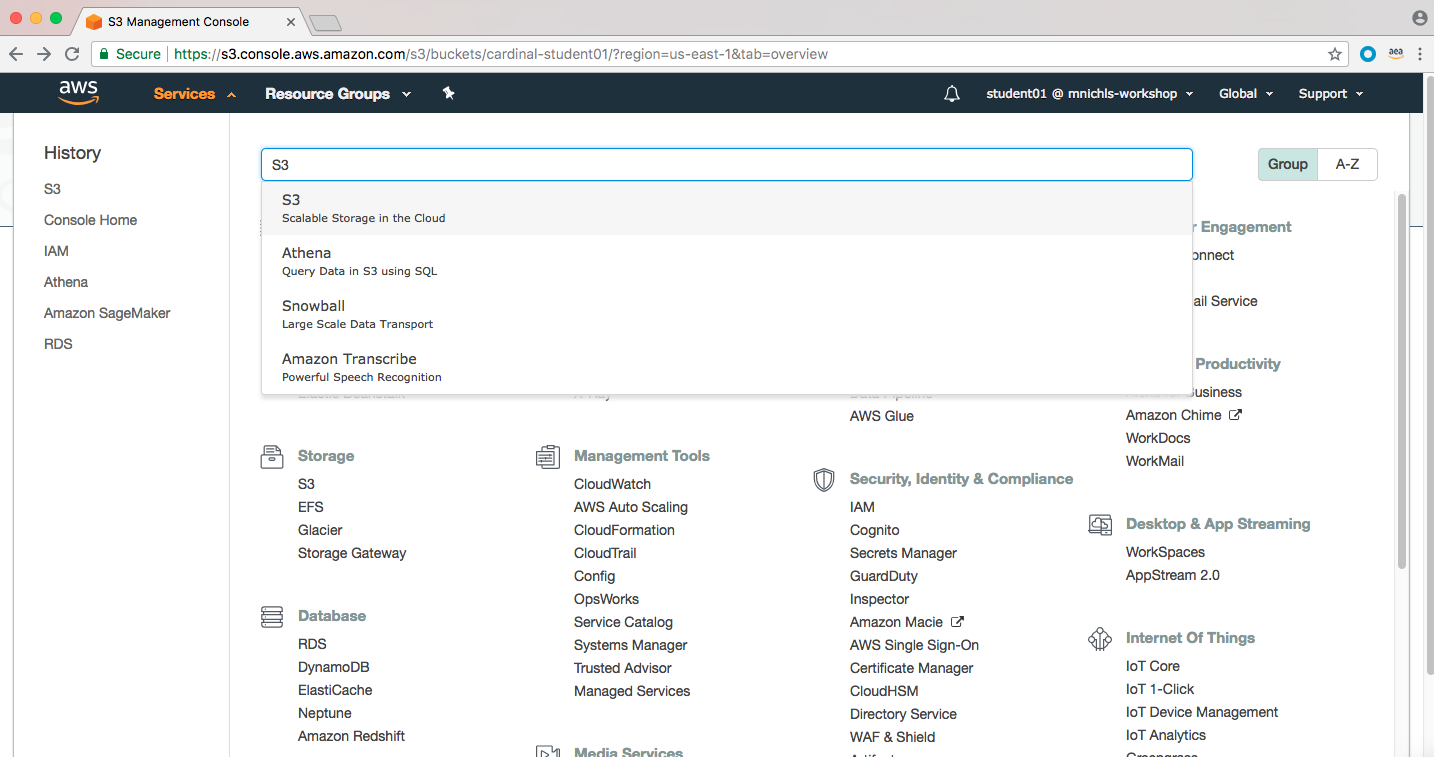

Create Bucket (make sure in US East(N. Virginia) and all lower case.

Create the 'data' folder (prefix)

Download the 'device_failure_rs.csv' from https://github.com/kyamz/ADS_Class/blob/master/device_failure.csv

then go to your bucket and paste

In [6]:
# create the s3 client
s3 = boto3.client('s3')

# this is the location of the data on S3 (usual)
bucket='sagemakerwherring' # put your S3 bucket name here
prefix = 'data'

# the data set is split into 3 csv files, change encoding to properly read
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/device_failure.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding="ISO-8859-1", low_memory=False)

# we expect 124,494 rows with 12 columns
print(df.shape)

(124494, 12)


### Explore
Now we have a dataframe in a Python3 Jupyter Notebook, you can move forward in data exploration as you normally would. 

In [7]:
#Sort and view the data
df=df.sort_values(['device','date']).reset_index(drop=True)
df.head(100)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7
5,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7
6,2015-05-06,S1F013BB,0,14533968,0,0,0,5,688952,0,0,0
7,2015-05-07,S1F013BB,0,46202296,0,0,0,5,688952,0,0,0
8,2015-05-08,S1F013BB,0,214383720,0,0,0,5,688964,0,0,0
9,2015-05-09,S1F013BB,0,243346080,0,0,0,5,689035,0,0,0


In [8]:
df.describe()
# notice atttribute7 & 8

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


### Initial data understanding and create the train/test partition

Summary of the insight gained from each line of code below:
* No nulls in the dataset.
* Device failures are rare in the un-altered dataset, with a mean of only .00851.
* About 9% of devices have a recorded failure. We will likely need to group by devices to help with the class imbalance of only .00851 failures per device day.
* We have data for 1,168 devices within 11 months of data from Jan to Nov 2015.




In [9]:
print ('basic dataframe info')
print (df.info())
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
print ('\nthe number of unique devices: '+str(df.device.nunique()))

#split into train and test
devices=df.device.unique()
np.random.seed(RANDOM_STATE)
msk = np.random.randn(len(devices)) < 0.8
traindevices=devices[msk]
testdevices= devices[~msk]
print ('the number of train devices: '+str(len(traindevices)))
print ('the number of test devices: '+str(len(testdevices)))
df['training_partition']=df.device.isin(traindevices)

print ('\nWe will only be viewing using train data until further notice.')

print ('\nthe number of unique dates: '+str(df[df.training_partition].date.nunique()))
print ('min date: '+str(df[df.training_partition].date.min()))
print ('max date: '+str(df[df.training_partition].date.max()))

print ('\ncounting the unique start dates for each device')
failure_sums=df[df.training_partition].groupby(['device'])['date'].min().reset_index()
failure_sums.columns=['device','start_date']
print(failure_sums.groupby(['start_date'])['device'].count())

print ('\nnumber of devices having a failure vs not failing')
failure_sums=df[df.training_partition].groupby(['device'])['failure'].sum().reset_index()
failure_sums.columns=['device','fail_count']
print(failure_sums.groupby(['fail_count'])['device'].count())

print ('\ndf.describe()')
print(df.describe())
print('\nprint the top of the train dataframe')
df[df.training_partition].head(1000)

basic dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB
None

the number of unique devices: 1168
the number of train devices: 934
the number of test devices: 234

We will only be viewing using train data until further notice.

the number of unique dates: 304
min date: 2015-01-01 00:00:00
max date: 2015-11-02 00:00:00

counting the unique start dates for each device
start_date
2015-01-01    931
2015-01-27      1
2015-05-06      2
Name:

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,training_partition
6,2015-05-06,S1F013BB,0,14533968,0,0,0,5,688952,0,0,0,True
7,2015-05-07,S1F013BB,0,46202296,0,0,0,5,688952,0,0,0,True
8,2015-05-08,S1F013BB,0,214383720,0,0,0,5,688964,0,0,0,True
9,2015-05-09,S1F013BB,0,243346080,0,0,0,5,689035,0,0,0,True
10,2015-05-10,S1F013BB,0,85127128,0,0,0,5,689062,0,0,0,True
11,2015-05-11,S1F013BB,0,115676688,0,0,0,5,689161,0,0,0,True
72,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,True
73,2015-01-02,S1F01R2B,0,200864456,0,0,0,15,313173,0,0,3,True
74,2015-01-03,S1F01R2B,0,196415520,0,0,0,15,313173,0,0,3,True
75,2015-01-04,S1F01R2B,0,127529600,0,0,0,15,314088,0,0,3,True


#### Drop Duplicate Feature
Remove one from the pair of perfectly correlated variables (att7 and att8). It looks like attributes 7 and 8 are giving the same information. A correlation analysis confirms.

In [10]:
print ('correlation between attributes 7 and 8')
print (df[['attribute7','attribute8']].corr())
df=df.drop('attribute8',axis=1)

correlation between attributes 7 and 8
            attribute7  attribute8
attribute7         1.0         1.0
attribute8         1.0         1.0


#### Remove Failure Records

In [11]:
#1.5 Viewing failed devices to develop hypotheses, and drop actual failure day from modeling data
#Let's look now at the failing devices and see if we can see any patterns or create any hypotheses.
failed_device_list=df[df.failure==1].device.unique()
print ('failed device list:')
print (failed_device_list)

#drop any data from when failure==1, as our goal is to predict if a device will fail BEFORE
#we have that information. This is a key step for our modeling process, as it is critical for
#accurately understanding how our model will do in the real world.
df=df[df.failure==0]

print ('view data for devices that fail')
df[df.device.isin(failed_device_list) & (df.training_partition==True)].sort_values(['device','date'])

failed device list:
['S1F023H2' 'S1F03YZM' 'S1F09DZQ' 'S1F0CTDN' 'S1F0DSTY' 'S1F0F4EB'
 'S1F0GG8X' 'S1F0GJW3' 'S1F0GKFX' 'S1F0GKL6' 'S1F0GPFZ' 'S1F0GSD9'
 'S1F0GSHB' 'S1F0J5JH' 'S1F0JD7P' 'S1F0JGJV' 'S1F0L0DW' 'S1F0LCTV'
 'S1F0LCVC' 'S1F0LD15' 'S1F0LD2C' 'S1F0P3G2' 'S1F0PJJW' 'S1F0QF3R'
 'S1F0QY11' 'S1F0RR35' 'S1F0RRB1' 'S1F0RSZP' 'S1F0S2WJ' 'S1F0S4CA'
 'S1F0S4EG' 'S1F0S4T6' 'S1F0S57T' 'S1F0S65X' 'S1F0T2LA' 'S1F0TQCV'
 'S1F10E6M' 'S1F11MB0' 'S1F13589' 'S1F135TN' 'S1F136J0' 'S1F13H80'
 'W1F03D4L' 'W1F03DP4' 'W1F08EDA' 'W1F0F6BN' 'W1F0FKWW' 'W1F0FW0S'
 'W1F0GCAZ' 'W1F0KCP2' 'W1F0M35B' 'W1F0M4BZ' 'W1F0NZZZ' 'W1F0P114'
 'W1F0PAXH' 'W1F0PNA5' 'W1F0Q8FH' 'W1F0SGHR' 'W1F0T034' 'W1F0T074'
 'W1F0T0B1' 'W1F0TA59' 'W1F0VDH2' 'W1F0WBTM' 'W1F0X4FC' 'W1F0X5GW'
 'W1F0Z1W9' 'W1F0Z3KR' 'W1F0Z4EA' 'W1F11ZG9' 'W1F1230J' 'W1F13SRV'
 'W1F14XGD' 'W1F15S4D' 'W1F19BPT' 'W1F1BFP5' 'W1F1BS0H' 'W1F1BZTM'
 'W1F1C9TE' 'W1F1C9WG' 'W1F1CB5E' 'W1F1CDDP' 'W1F1CJ1K' 'W1F1DQN8'
 'Z1F04GCH' 'Z1F0B4XZ' 'Z1F0FSBY' 'Z1F0K45

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,training_partition
407,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,3,True
408,2015-01-02,S1F023H2,0,161679800,0,0,1,19,495730,16,3,True
409,2015-01-03,S1F023H2,0,182358672,0,0,1,19,496974,16,3,True
410,2015-01-04,S1F023H2,0,204752808,0,0,1,19,497559,16,3,True
411,2015-01-05,S1F023H2,0,226982888,0,0,1,19,498753,16,3,True
412,2015-01-06,S1F023H2,0,10387472,0,0,1,19,499964,16,3,True
413,2015-01-07,S1F023H2,0,30083248,0,0,1,19,501239,16,3,True
414,2015-01-08,S1F023H2,0,55079280,0,0,1,19,502542,16,3,True
415,2015-01-09,S1F023H2,0,78898848,0,0,1,19,503812,16,3,True
416,2015-01-10,S1F023H2,0,107573856,0,0,1,19,505079,16,3,True


#### Engineer New Features

In [12]:
'''
1.6 Engineer new features for within-device variance in attributes 2, 3, 4, 7 and 9

Many features look like they are constant within a single device's history. Looking at within-device variance for 
each feature will confirm.
'''
device_featurevar=df.groupby(['device','training_partition']) \
    [df.drop(['date','failure','training_partition'],axis=1).columns].var().reset_index()
print ('within-device variance for each feature')
print (device_featurevar.head(5))
print ('\ndescribe the frequency of variance for each device')
print (device_featurevar.describe())
'''
Attributes 2, 3, 4, 7 and 9 all have a variance of zero for over 75% of devices.
Let's look now at how many devices we're dealing with in this list.
'''
devices_rare_variance=device_featurevar[(device_featurevar.attribute2>0)|(device_featurevar.attribute3>0)|
                                        (device_featurevar.attribute4>0)|(device_featurevar.attribute7>0)|
                                        (device_featurevar.attribute9>0)]
print('\nthe number of unique training data devices with activity for a rarely changing variable: '+
      str(devices_rare_variance[devices_rare_variance.training_partition==True].device.nunique()))

#164 of the 934 total devices have 'rare variance' 
#85 of the 934 total devices have a failure.
#Is there any relationship between these two features?
print('\nhow many training data devices intersect between the rare variance and failed devices lists?: '+
      str(len(set(devices_rare_variance[devices_rare_variance.training_partition==True].device).
              intersection(failed_device_list))))
#Nice! This will be a very helpful feature for us to detect risk of device failure. 63 of the 85 failing devices
#have this feature, and only 101 of the 849 non-failing devices have variance in attributes 2, 3, 4, 7 and 9.

'''It is also a good idea to take a look at the exceptions to our new feature to see if we can see what's going on.
Most of the time, it looks like devices that fail have a higher magnitude of 'rare variance' and also a
larger number of distinct values in attributes 2, 3, 4, 7 and 9; whereas devices that don't fail have only one or
two changes of a smaller magnitude. This information will be very helpful later on when we are building a model.
Thus, we will build features late on for number of unique values in attributes 2,3,4,7 and 9, and also for slope.
'''
tmpdf=df[df.device.isin(devices_rare_variance.device)&(df.training_partition==True)]
tmpdf=tmpdf[~tmpdf.device.isin(failed_device_list)].sort_values(['device','date'])
print ('\nlookng at the devices that do not follow our rule of rare variance being a leading indicator for failure')
tmpdf.head(10)

within-device variance for each feature
     device  training_partition    attribute1  attribute2  attribute3  \
0  S1F01085               False  4.744575e+15         0.0         0.0   
1  S1F013BB                True  8.385289e+15         0.0         0.0   
2  S1F0166B               False  6.890317e+15         0.0         0.0   
3  S1F01E6Y               False  4.649199e+15         0.0         0.0   
4  S1F01JE0               False  4.149062e+15         0.0         0.0   

   attribute4  attribute5    attribute6  attribute7  attribute9  
0         0.0         0.0  6.315783e+05         0.0         0.0  
1         0.0         0.0  6.849600e+03         0.0         0.0  
2         0.0         0.0  4.322178e+05         0.0         0.0  
3         0.0         0.0  4.416676e+07         0.0         0.0  
4         0.0         0.0  6.333546e+05         0.0         0.0  

describe the frequency of variance for each device
         attribute1    attribute2    attribute3     attribute4   attribut

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,training_partition
751,2015-01-01,S1F02MGA,0,44399688,0,266,1,6,399286,0,2269,True
752,2015-01-02,S1F02MGA,0,143057976,0,266,1,6,399286,0,2270,True
753,2015-01-03,S1F02MGA,0,133464400,0,266,1,6,399288,0,2270,True
754,2015-01-04,S1F02MGA,0,237306240,0,266,1,6,399346,0,2270,True
755,2015-01-05,S1F02MGA,0,111869224,0,266,1,6,400149,0,2270,True
756,2015-01-06,S1F02MGA,0,136441184,0,266,1,6,401421,0,2270,True
757,2015-01-01,S1F02P76,0,104131304,1536,0,175,11,301679,0,0,True
758,2015-01-02,S1F02P76,0,137391624,1536,0,175,11,301679,0,0,True
759,2015-01-03,S1F02P76,0,15483344,1536,0,175,11,301679,0,0,True
760,2015-01-04,S1F02P76,0,113919680,1592,0,215,11,301976,0,0,True


#### Anomalous Start Dates
Ideally we could discuss this with the business/operations owner to understand if there is a legitimate reason for the 3 devices with start dates other than Jan 1, 2015.

In [13]:
'''
1.7 Drop devices with an anomalous start date.

What's going on with the devices that have a start date different from 2015-01-01? Temperature and weather
conditions will likely be associated with device failures so it would be nice to have all devices in our
data start on the same date. If there are only 3 of 934 with an anomalous start date, it's likely best to just
drop them.
'''
device_start_dates=df[df.training_partition==True].groupby(['device'])['date'].min().reset_index()
device_start_dates.columns=['device','start_date']
print ('start date for each device, sorted in descending order')
print (device_start_dates.sort_values(['start_date'], ascending=False).reset_index(drop=True).head(5))


#badstartdate_devices=device_start_dates[pd.to_datetime(pd.Series(device_start_dates.start_date))>date(2015, 1, 1)].device.unique()
badstartdate_devices=device_start_dates[device_start_dates.start_date > '2015-01-01'].device.unique()


print('\nIt is important to note that none of the devices with bad start dates are in the failed device list: '+str(len(set(badstartdate_devices).intersection(failed_device_list))))
print('Nor do any of them have variance in attributes 2, 3, 4, 7 and 9: '+str(len(set(badstartdate_devices).intersection(devices_rare_variance.device))))
#For the two reasons listed above, let's just drop these three devices that are creating inconsistency without
#providing much extra value.
df=df[-df.device.isin(badstartdate_devices)]
print ('number of remaining devices: '+str(df[df.training_partition==True].device.nunique()))

start date for each device, sorted in descending order
     device start_date
0  S1F013BB 2015-05-06
1  S1F02XLX 2015-05-06
2  W1F0976M 2015-01-27
3  W1F0X7PR 2015-01-01
4  W1F0X5VA 2015-01-01

It is important to note that none of the devices with bad start dates are in the failed device list: 0
Nor do any of them have variance in attributes 2, 3, 4, 7 and 9: 0
number of remaining devices: 931


#### Inspect the Time Series Data

In [14]:
'''
1.8 Looking at gaps in the time series data for a device

An important consideration when we are deciding on if a time-series model is feasible is determining
if we have data every day for each device or if there are periodic gaps in the sensor records
'''
device_end_dates=df.groupby(['device'])['date'].max().reset_index()
device_end_dates.columns=['device','end_date']
device_start_dates=df.groupby(['device'])['date'].min().reset_index()
device_start_dates.columns=['device','start_date']
device_duration=device_start_dates.merge(device_end_dates,on='device')
device_duration['min_to_maxdate']=(device_duration.end_date-device_duration.start_date).astype('timedelta64[D]').astype(int)+1

device_counts=df.groupby(['device'])['date'].nunique().reset_index()
device_counts.columns=['device','counts']
device_duration=device_duration.merge(device_counts,on='device')
device_duration['% missing']=((device_duration.min_to_maxdate-device_duration.counts)/device_duration.min_to_maxdate)*100
device_duration['data gap']=(device_duration['% missing']>0)

device_duration['device fails']=device_duration.device.isin(failed_device_list)
device_duration['rare variance']=device_duration.device.isin(devices_rare_variance.device)
tmp=device_duration.groupby(['device fails','data gap'])['device'].nunique().reset_index()
print(tmp)
tmp=device_duration.groupby(['rare variance','data gap'])['device'].nunique().reset_index()
print(tmp)
'''
Many devices have large gaps in their record.
A data gap decreases the likelihood of failure, but the effect is minimal.

Nor is there any obvious relationship between data gaps and the likelihood of 'rare variance'. I was expecting
gaps in data to decrease the likelihood of rare variance, but it actually slightly increases that likelihood. 
'''

#t-tests looking at likelihood of device failure and the number of records for the device. 
#No relationship found.
group1 = device_duration[device_duration['device fails'] == True]
group2 = device_duration[device_duration['device fails'] == False]
t, p = scipy.stats.ttest_ind(group1.counts, group2.counts)
print ('\nt test for device failure likelihood and number of records')
print ('t is '+str(t))
print ('p is '+str(p))

#t-tests looking at likelihood of rare variance and the number of records for the device. 
#No relationship found.
group1 = device_duration[device_duration['rare variance'] == True]
group2 = device_duration[device_duration['rare variance'] == False]
t, p = scipy.stats.ttest_ind(group1.counts, group2.counts)
print ('\nt test for rare variance and number of records')
print ('t is '+str(t))
print ('p is '+str(p)) 
#interesting. there is a significant relationship between the number of records for a device and if
#the device will have rare variance.
print ('record count mean for rare_variance==True: '+str(group1.counts.mean()))
print ('record count mean for rare_variance==False: '+str(group2.counts.mean()))
#The combination of rare variance and # of records will be useful in modeling device failures.

'''To summarize what we've learned in this code block: number of device records does not increase the 
likelihood that the device will fail, but it does increase the likelihood that the device will have
rare variance. My hope is that the interaction between #records and rare variance will help the model
distinguish when to predict 'failure' and when to back off because the device just has a lot of data and
so some small amount of variance is to be expected. 
Later we'll create a slope variable to capture this interaction.
'''
device_duration.sort_values('% missing', ascending=False).reset_index(drop=True)

   device fails  data gap  device
0         False     False     904
1         False      True     155
2          True     False      88
3          True      True      18
   rare variance  data gap  device
0          False     False     836
1          False      True     132
2           True     False     156
3           True      True      41

t test for device failure likelihood and number of records
t is -0.6811544327106575
p is 0.49590937727699413

t test for rare variance and number of records
t is 3.0144340055747096
p is 0.0026303854263878047
record count mean for rare_variance==True: 126.55837563451777
record count mean for rare_variance==False: 102.4659090909091


,device,start_date,end_date,min_to_maxdate,counts,% missing,data gap,device fails,rare variance
0,Z1F1AG5N,2015-01-01,2015-05-07,127,8,93.700787,True,True,True
1,S1F0QZXV,2015-01-01,2015-05-11,131,9,93.129771,True,False,False
2,Z1F0M7QD,2015-01-01,2015-05-11,131,9,93.129771,True,False,False
3,S1F0QYX3,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
4,S1F11AXR,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
5,S1F13699,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
6,S1F13BTN,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
7,W1F0W2BX,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
8,W1F0W0RV,2015-01-01,2015-05-11,131,12,90.839695,True,False,False
9,W1F0X5KX,2015-01-01,2015-05-11,131,12,90.839695,True,False,False


#### How Long do Devices Last

the number of devices whose last recorded day is in the given month. split by fail/no-fail groups.
fails_bool   False  True 
month                    
1           1057.0  106.0
2            648.0   77.0
3            619.0   65.0
4            437.0   53.0
5            371.0   50.0
6            322.0   29.0
7            322.0   23.0
8            325.0    8.0
9            180.0    3.0
10           142.0    3.0
11            31.0    NaN
same thing as the numbers above, but this time the y-axis is for week number rather than month number



Text(0.5,1,'Duration of Training Device by Failure')

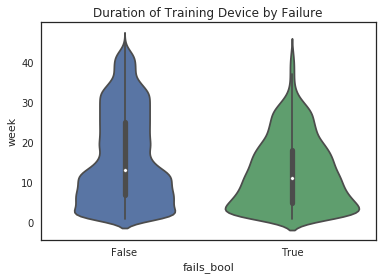

In [15]:
'''
1.9 Examining patterns in how many days a device lasts and if it differs between fail/no-fail groups.

Examining week/month of year would be a useful feature to include, in my experience, temperature and age can 
have a harmful effect on device durability.'''

#df["month"] = pd.DatetimeIndex(df["date"]).month
#df["week"] = (pd.to_datetime(df["date"])-date(2015,1,1)).astype('timedelta64[D]').astype(int)//7
df["month"] = df['date'].dt.month
df["week"] = df['date'].dt.week

tmpdf=df[['device','month']]
tmpdf['fails_bool']=tmpdf.device.isin(failed_device_list)
devices_by_month=tmpdf.groupby(['month','fails_bool'])['device'].nunique().reset_index()
print ('the number of devices whose last recorded day is in the given month. split by fail/no-fail groups.')
print (devices_by_month.pivot(index='month',columns='fails_bool',values='device'))

'''We have two periods of large drop-offs in the no-fail device list: within 1 month, and in the 3rd month.
Ideally we would want every device to either make it to the end of dataset's time period or end in failure.

What should we do with the devices that don't end in failure but whose data record ends ubruptly? 
One option would be to use a hazard-type model. This way we can still make use of the data that comes from a 
device whose data is censored before a failure event. Hazard models predict time-to-event and are commonly
used in life insurance applications. The downside of hazard models is a strict set of prior assumptions that 
must be met to correctly use the model.

A second option is to drop entirely the devices whose end dates are artificially censored (an end date without a 
recorded failure). However, this would mean eliminating most of our data. Another problem with this approach
is that many of these devices are likely only having a 'data gap' and will return to our dataset in future days.
A compromise hear would be to drop no-fail devices with a very small range worth of data ie max_date-min_date<7. The
modeling goal would still likely be a survival-type model. 

The third option is to just leave all devices in the dataset, even the ones with only a few days of data, group
all the data by device ID and make our modeling strategy to build a binary classifier targeting if the device will
have a failure record or not.
A risk here is that some devices will be missing failure recordings because of cut off dates happening just before 
a failure event. These occurences will trick the model by looking like impending failures that never occur in 
our dataset. This is especailly risky if we define our target model to be something like 'failure will happen
within next week, month, etc).
'''
tmpdf=df[df.training_partition==True][['device','week']]
tmpdf['fails_bool']=tmpdf.device.isin(failed_device_list)
devices_by_week=tmpdf.groupby(['week','fails_bool'])['device'].nunique().reset_index()
print ('same thing as the numbers above, but this time the y-axis is for week number rather than month number\n')
sns.violinplot(x="fails_bool", y="week", data=tmpdf).set_title('Duration of Training Device by Failure')

#### Natural Groupings by Device ID
This is yet another example of where working closely with the business owner is highly valuable. Could the difference in the noted device ID groups be purely by chance or is there a significance to the name with respect to their use, production materials, plant produced at, etc.

failure rate for each device category
  device_cat  num_devices  num_failures  failure_rate %
0          S          415        3580.0        8.626506
1          W          343        3667.0       10.690962
2          Z          173        1473.0        8.514451

pairplots split by device category
have patience. this one takes a few minutes to run


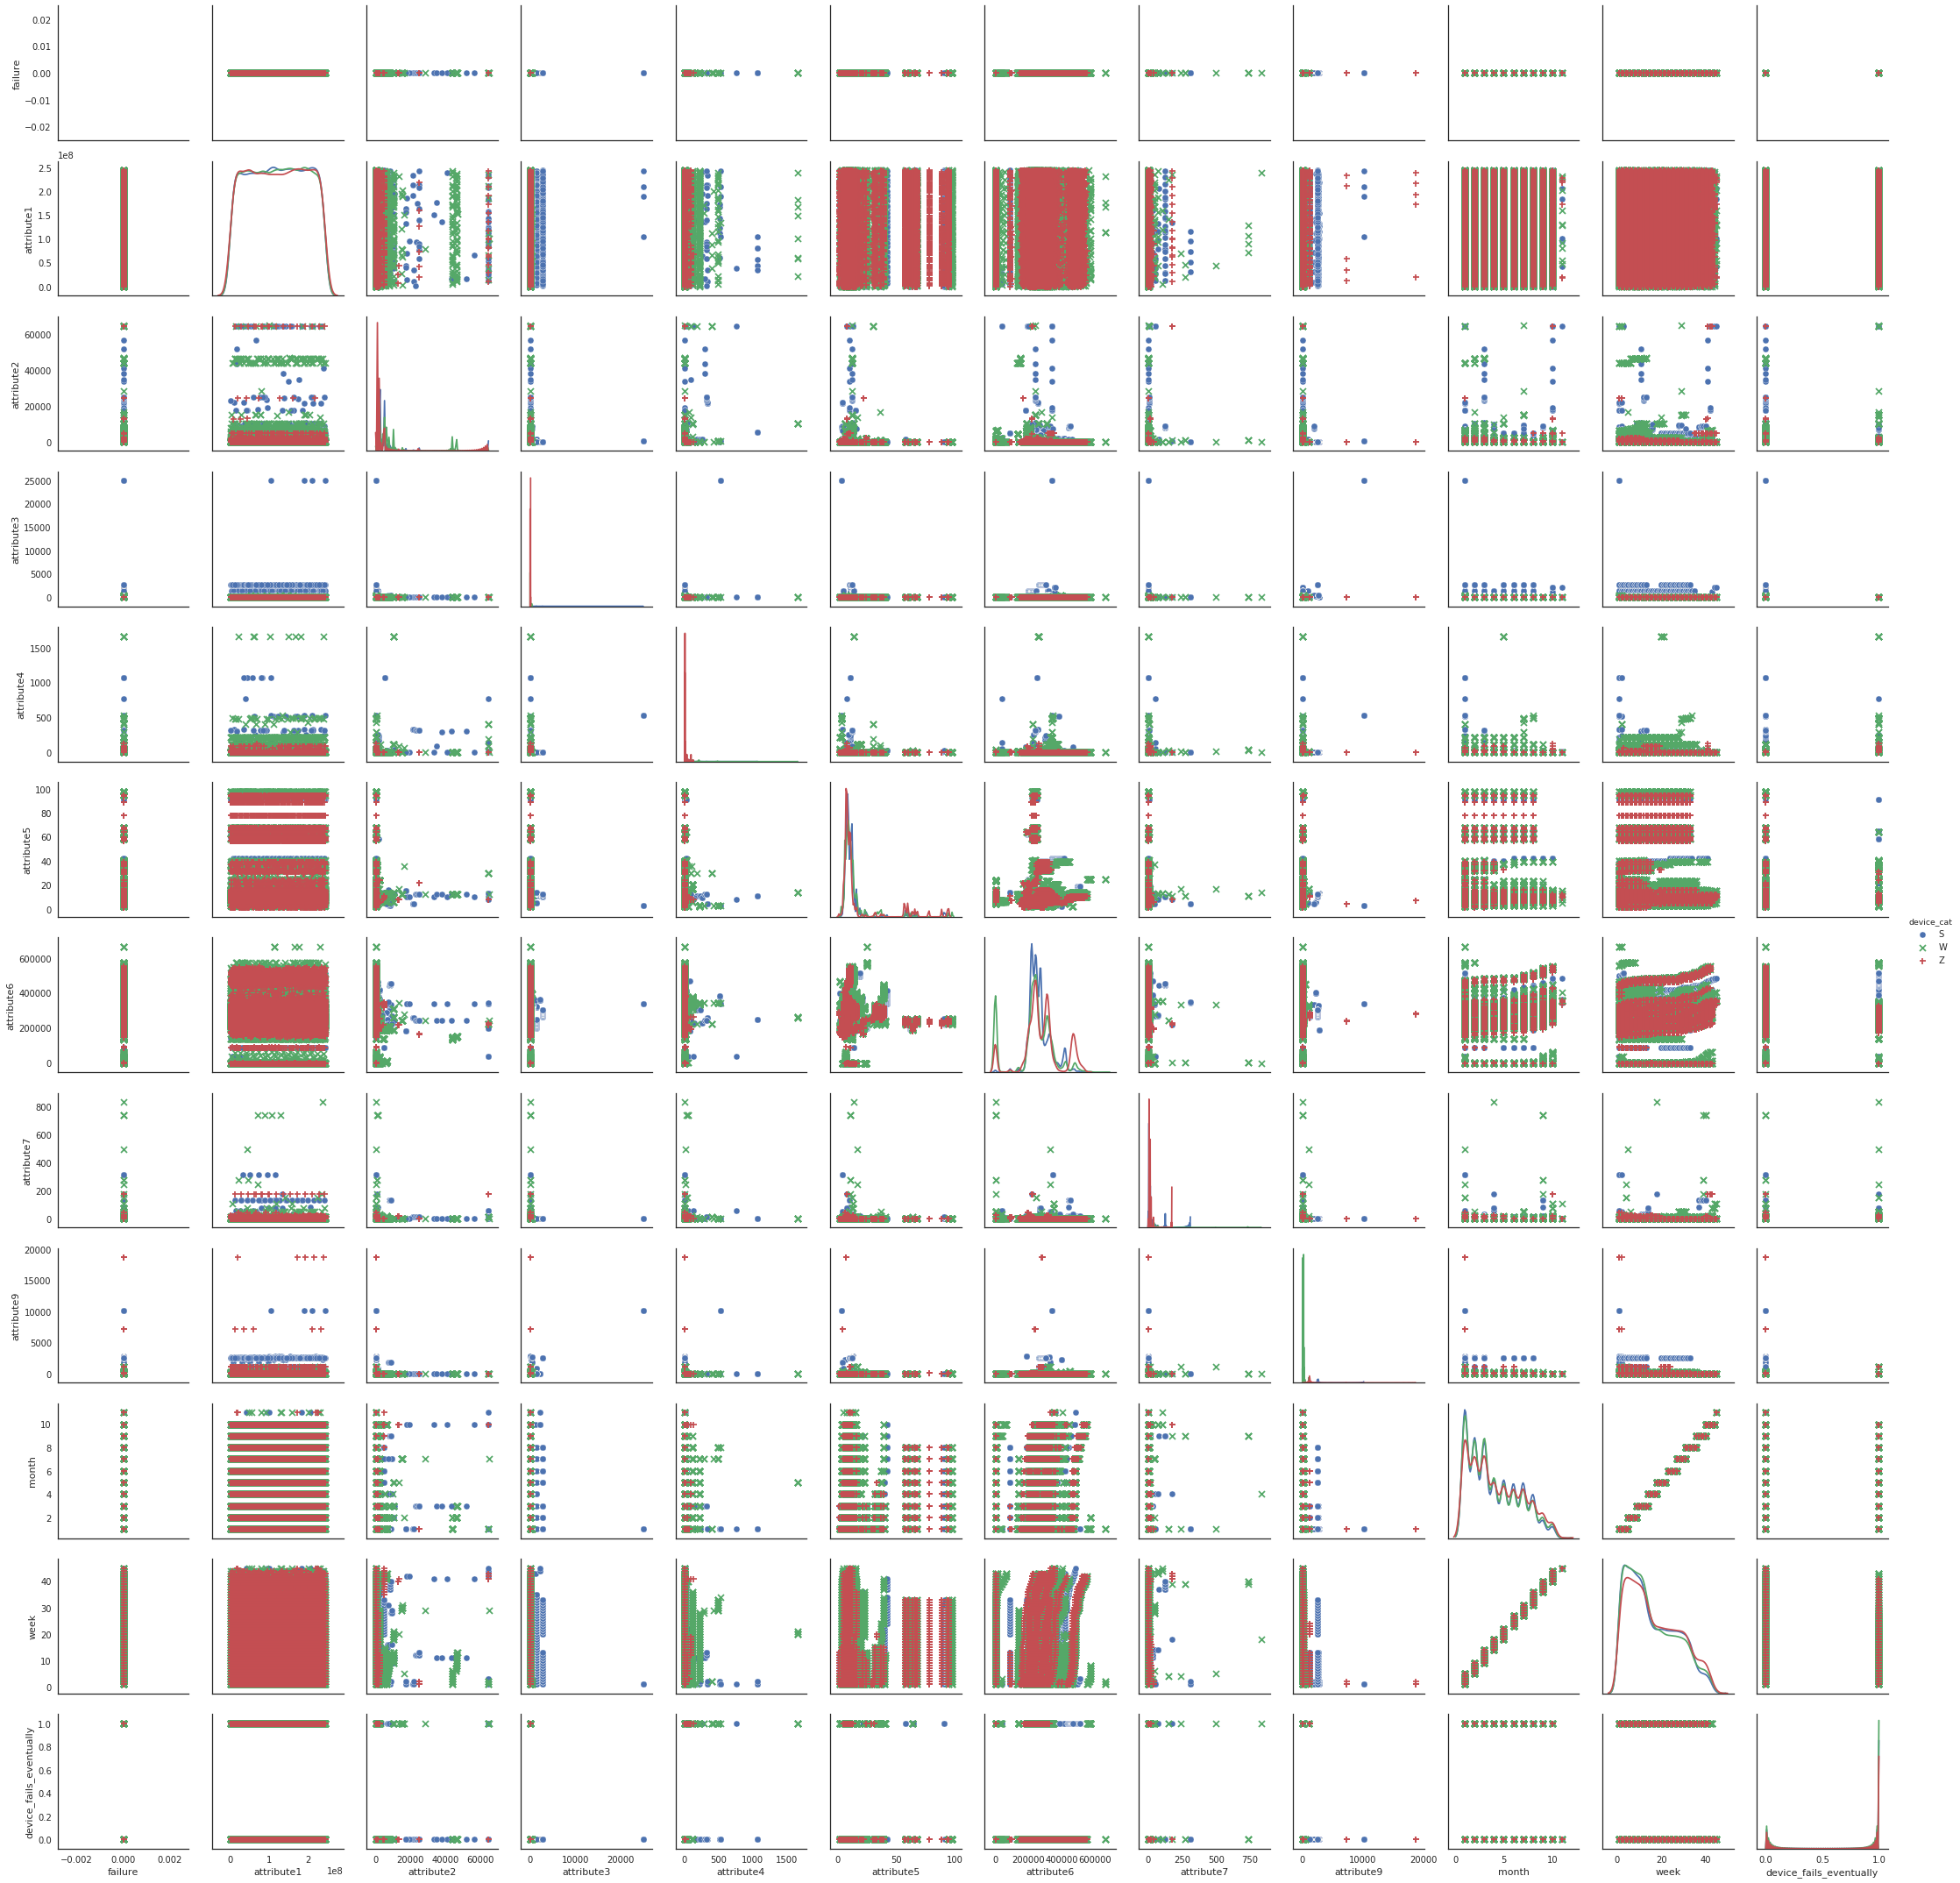

In [16]:
'''
1.10 Creating a feature for device category and showing a pairplot

One fact that I've learned from previous data science work with devices and parts is that the ID string 
often contains useful information about the type or generation of the machine. Sure enough, it looks 
like there are three possibilities: S, W and Z. Let's look further into these 'type codes' by counting their
frequency and failure rates per day of recorded data.
'''
df['device_cat']=df.device.str.slice(0,1)
df['device_fails_eventually']=df.device.isin(failed_device_list)
device_counts=df[df.training_partition==True].groupby(['device_cat'])['device'].nunique().reset_index()
device_failurecounts=df[df.training_partition==True].groupby(['device_cat']) \
    ['device_fails_eventually'].sum().reset_index()
joined=pd.merge(device_counts, device_failurecounts, how='inner', on=['device_cat'])
joined.columns=['device_cat','num_devices','num_failures']
joined['failure_rate %']=joined.num_failures/joined.num_devices
print ('failure rate for each device category')
print (joined)
'''This is a useful finding. W-type devices are more likely to fail than the other two groups.

A pairplot also demonstrates that there are major differences in the sensor data across groups: 
ie intersection of attributes 1&3. When modeling, let's try a different model for each category to 
see if there are any underlying differences between groups.
z=blue,w=green,s=red
'''
print ('\npairplots split by device category')
print ('have patience. this one takes a few minutes to run')
sns.pairplot(df[df.training_partition==True].drop(['date','device','training_partition'],axis=1),
             hue="device_cat", diag_kind="kde",markers=['o','x','+'])

#### Outliers

In [17]:
'''
1.11 Cleaning up the outliers

Another step before modeling is to clean up some of the outliers that the pairplots show most clearly:
attributes 3, 4, and 7
'''

#Attribute 3
print ('attribute 3 cleaning')
df[(df.training_partition==True)&(df.attribute3>15000)].device.unique()
print(df[(df.device=='S1F04KSC')])
#since this device also only has 4 days worth of data and it's also responsible for our attribute 9 outliers,
# let's just drop it.
df=df[~(df.device=='S1F04KSC')]
print ('number of devices left: '+str(df.device.nunique()))

#Attribute 4
print ('\nattribute 4 cleaning')
print (df[(df.training_partition==True)&(df.attribute4>1000)].device.unique())
print('the top five att4 values for the W device cat: '+
      str(sorted(df[(df.device_cat=='W')].attribute4.unique())[-5:]))
df.loc[df['attribute4']>1000,'attribute4'] = 550

#Attribute 7
print ('\nattribute 7 cleaning')
print (df[(df.training_partition==True)&(df.attribute7>300)].device.unique())
print('the top five att7 values for the W device cat: '+
      str(sorted(df[(df.device_cat=='W')].attribute7.unique())[-5:]))
df.loc[df['attribute7']>300,'attribute7'] = 300

attribute 3 cleaning
           date    device  failure  attribute1  attribute2  attribute3  \
1316 2015-01-01  S1F04KSC        0   105234552         392       24929   
1317 2015-01-02  S1F04KSC        0   209131472         392       24929   
1318 2015-01-03  S1F04KSC        0   189393960         392       24929   
1319 2015-01-04  S1F04KSC        0   243217648         392       24929   

      attribute4  attribute5  attribute6  attribute7  attribute9  \
1316         529           3      339205           0       10137   
1317         529           3      339205           0       10137   
1318         529           3      339205           0       10137   
1319         529           3      339302           0       10137   

      training_partition  month  week device_cat  device_fails_eventually  
1316                True      1     1          S                    False  
1317                True      1     1          S                    False  
1318                True      1     1  

#### Pairplot with Outliers Removed

have patience. this one takes a few minutes to run


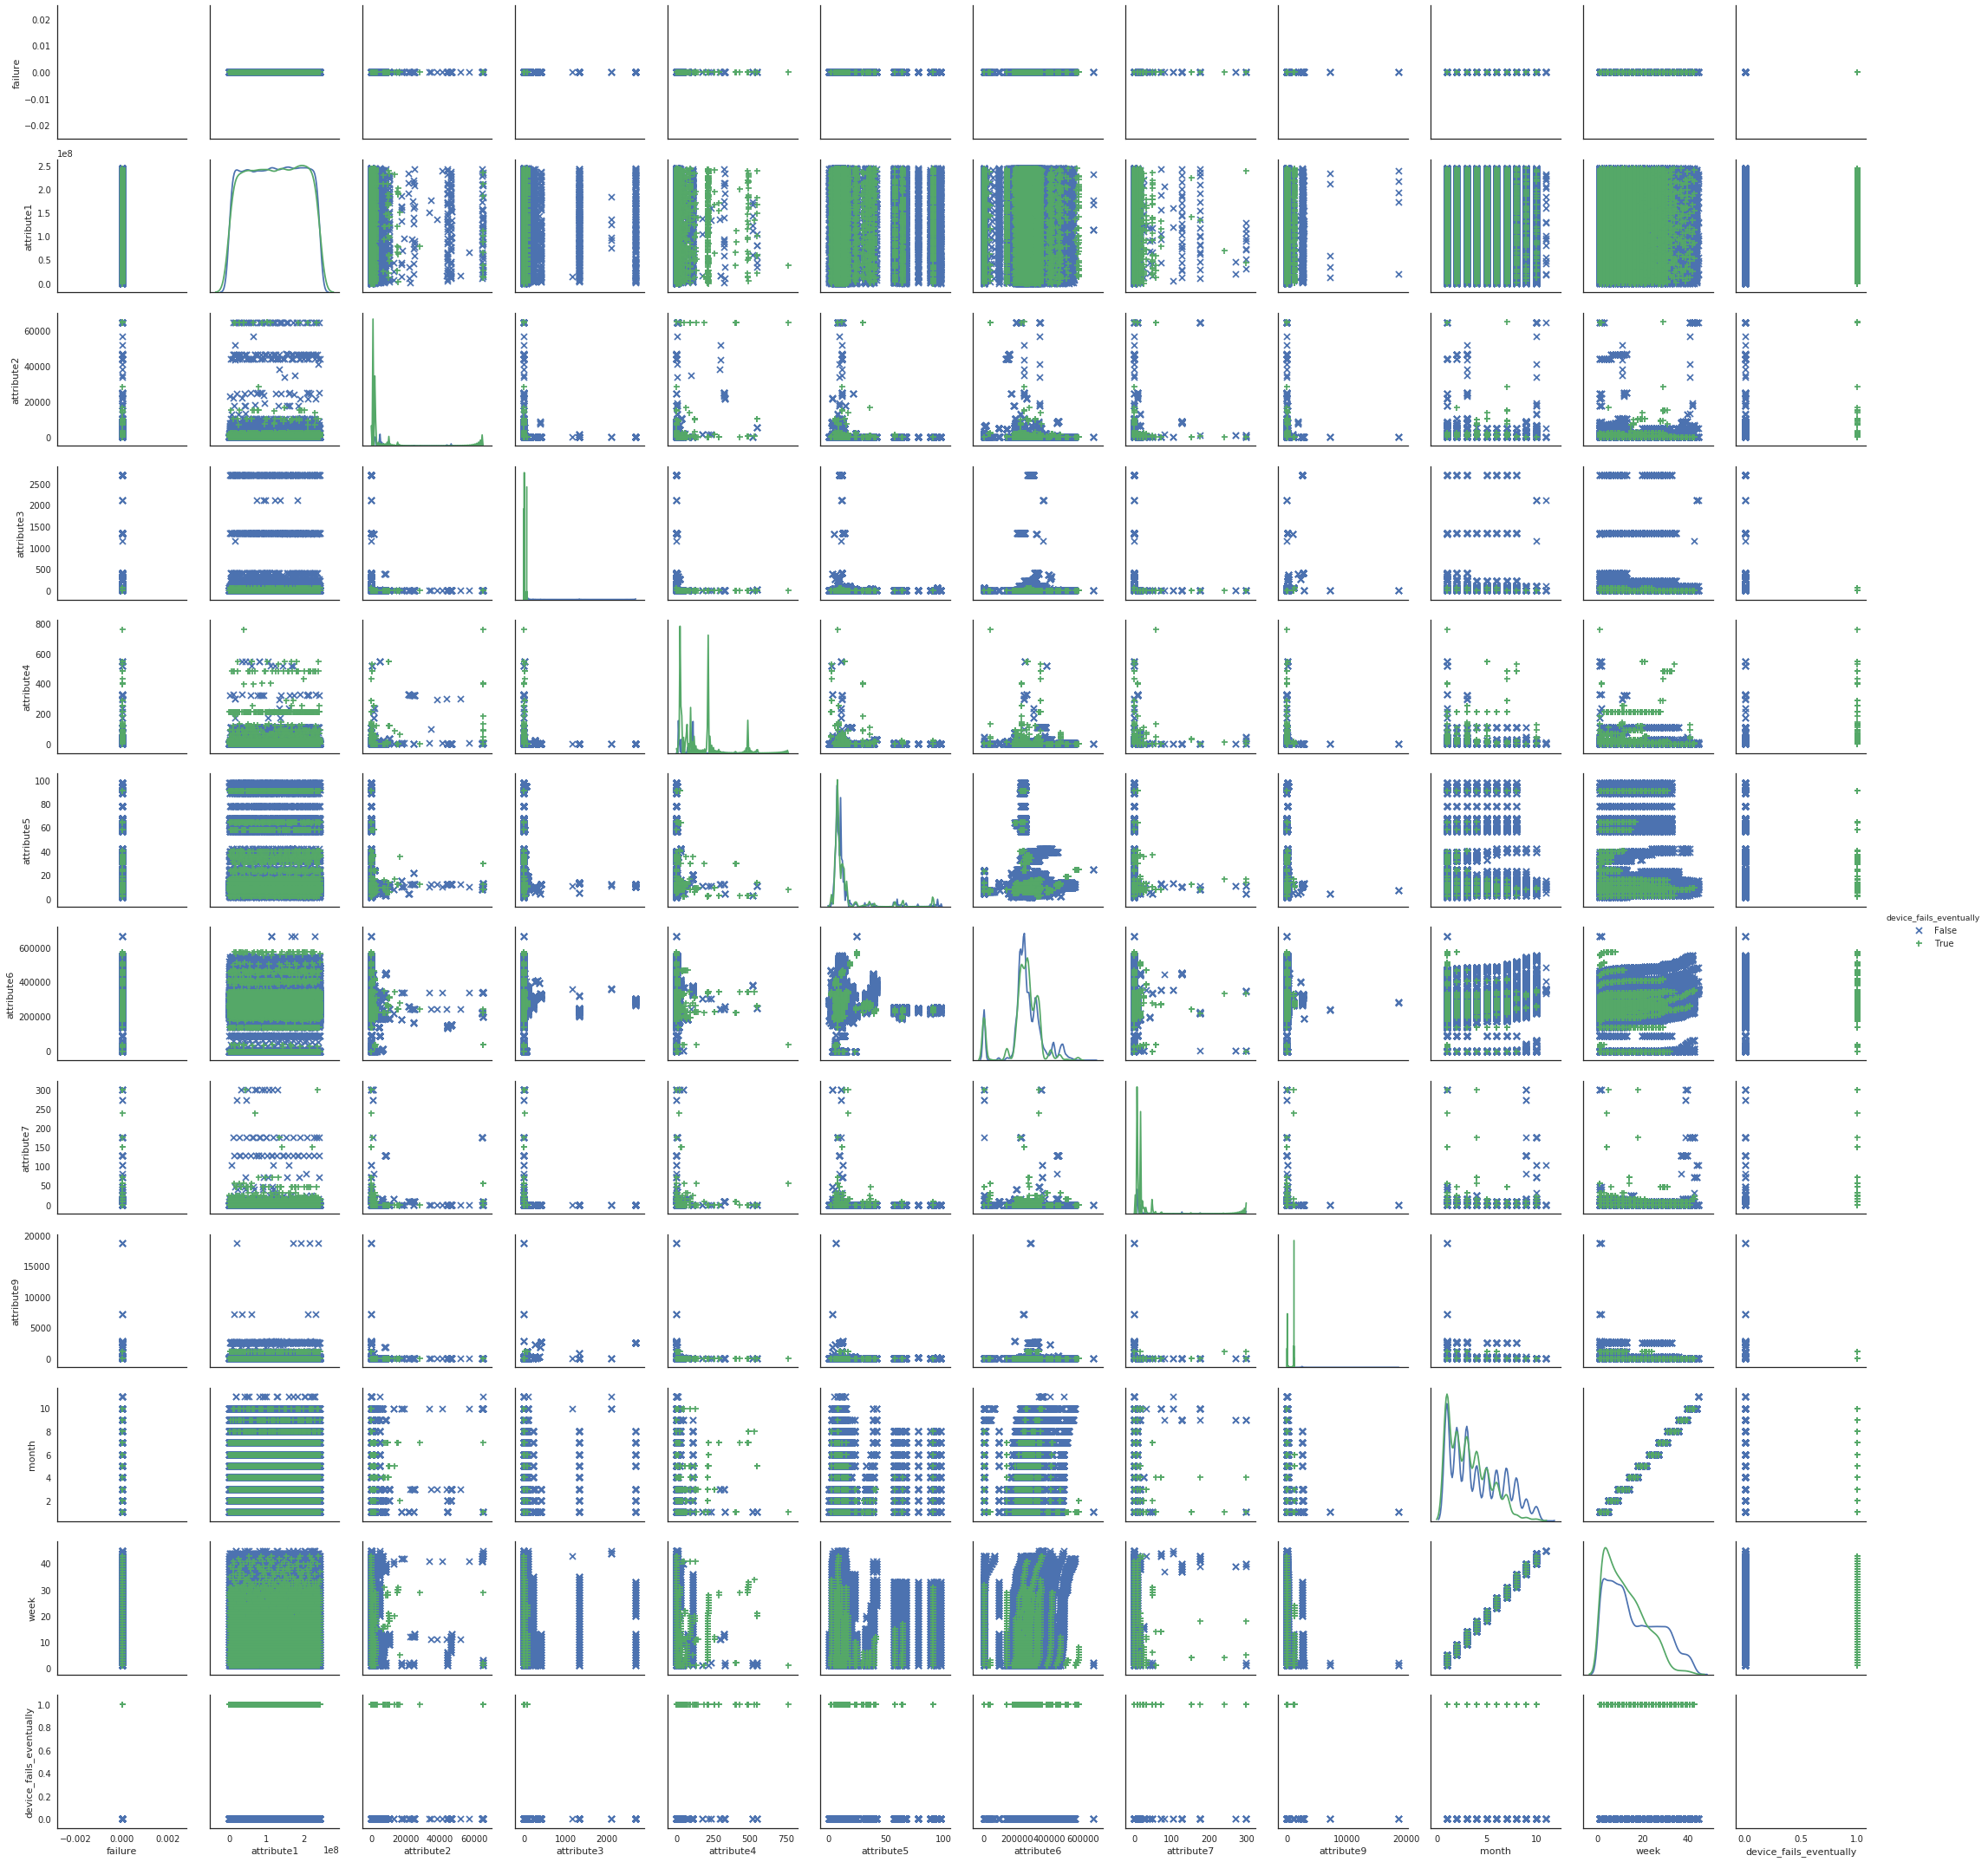

In [18]:
''' 
1.12 Another pairplot for the cleaned data, this time coloring by if the device is in the failure group.

Notice how much more legible the pair plots are after trimming only a few outliers.
It is also useful to see how these pairplots differ for hue="device_fails_eventually", rather than hue="device_cat"
failed=green not_failed=blue
'''
print ('have patience. this one takes a few minutes to run')
sns.pairplot(df[df.training_partition==True].drop(['date','device','training_partition'],axis=1),
             hue="device_fails_eventually", diag_kind="kde", markers=['x','+'])

### Transformation
#### Modelling Strategy
The project description is unclear on if/how we should aggregate the data. Thus, let's use option 3 explained above in section 1.9. The third option is to just leave all devices in the dataset, even the ones with only a few days of data, group all the data by device ID and make our modeling strategy to build a binary classifier targeting if the device will have a failure record or not.

In [22]:
print ('a review of what features we were given, what we dropped, and what we added')
print (df.columns)

a review of what features we were given, what we dropped, and what we added
Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'training_partition', 'month', 'week', 'device_cat'],
      dtype='object')


#### Aggregate Data by Device to Create the Features

In [23]:
'''
2.2 Aggregate data by device and create the modeling features

Type 1 aggregate by device number: doing this effectively will require creating features that effectively
represent the distribution of the attributes for each device and then learning a model based on those new features.
'''

df=df.drop('device_fails_eventually',axis=1)

#stdev for each attribute (related to our 'rare variance' discussion above) grouped by device
device_std=df.groupby(['device','device_cat','training_partition'])[df.drop(['date','failure','month','week','training_partition'],axis=1).columns].std().reset_index()
device_std.columns=['device','device_cat','training_partition','att1_std','att2_std','att3_std','att4_std','att5_std','att6_std','att7_std','att9_std']
one_hot=pd.get_dummies(device_std['device_cat'])
device_std=device_std.drop('device_cat',axis=1)
device_std=device_std.join(one_hot)
#print(device_std.sort('att1_std').head(10))

#max for each attribute grouped by device
device_max=df.groupby('device')[df.drop(['date','failure','device_cat','month','week','training_partition'],axis=1).columns].max().reset_index(drop=True)
device_max.columns=['device','att1_max','att2_max','att3_max','att4_max','att5_max','att6_max','att7_max','att9_max']
#print(device_max.head(5))

#min for each attribute grouped by device
device_min=df.groupby('device')[df.drop(['date','failure','device_cat','month','week','training_partition'],axis=1).columns].min().reset_index(drop=True)
device_min.columns=['device','att1_min','att2_min','att3_min','att4_min','att5_min','att6_min','att7_min','att9_min']
#print(device_min.head(5))

#range for each attribute grouped by device
device_range=device_max.merge(device_min,on='device')
device_range['att1_range']=device_range.att1_max-device_range.att1_min
device_range['att2_range']=device_range.att2_max-device_range.att2_min
device_range['att3_range']=device_range.att3_max-device_range.att3_min
device_range['att4_range']=device_range.att4_max-device_range.att4_min
device_range['att5_range']=device_range.att5_max-device_range.att5_min
device_range['att6_range']=device_range.att6_max-device_range.att6_min
device_range['att7_range']=device_range.att7_max-device_range.att7_min
device_range['att9_range']=device_range.att9_max-device_range.att9_min

device_features=device_std.merge(device_range,on='device')
other_features=device_duration.drop(['start_date','end_date'],axis=1)
data_modeling=other_features.merge(device_features,on='device')

data_modeling['att1_slope']=data_modeling.att1_range/data_modeling.counts
data_modeling['att2_slope']=data_modeling.att2_range/data_modeling.counts
data_modeling['att3_slope']=data_modeling.att3_range/data_modeling.counts
data_modeling['att4_slope']=data_modeling.att4_range/data_modeling.counts
data_modeling['att5_slope']=data_modeling.att5_range/data_modeling.counts
data_modeling['att6_slope']=data_modeling.att6_range/data_modeling.counts
data_modeling['att7_slope']=data_modeling.att7_range/data_modeling.counts
data_modeling['att9_slope']=data_modeling.att9_range/data_modeling.counts

att2nunique=df.groupby(['device'])['attribute2'].nunique().reset_index()
att2nunique.columns=['device','att2nunique']
att3nunique=df.groupby(['device'])['attribute3'].nunique().reset_index()
att3nunique.columns=['device','att3nunique']
att4nunique=df.groupby(['device'])['attribute4'].nunique().reset_index()
att4nunique.columns=['device','att4nunique']
att7nunique=df.groupby(['device'])['attribute7'].nunique().reset_index()
att7nunique.columns=['device','att7nunique']
att9nunique=df.groupby(['device'])['attribute9'].nunique().reset_index()
att9nunique.columns=['device','att9nunique']

data_modeling=pd.merge(data_modeling, att2nunique, how='inner', on=['device'])
data_modeling=pd.merge(data_modeling, att3nunique, how='inner', on=['device'])
data_modeling=pd.merge(data_modeling, att4nunique, how='inner', on=['device'])
data_modeling=pd.merge(data_modeling, att7nunique, how='inner', on=['device'])
data_modeling=pd.merge(data_modeling, att9nunique, how='inner', on=['device'])

print(data_modeling.columns)
print(data_modeling.shape)
data_modeling.head(5)


ValueError: labels ['device_fails_eventually'] not contained in axis

In [25]:
# look at data types. We will need to convert to all numeric and add a validation set
dm_xgb = data_modeling.copy()
data_modeling.dtypes

device                 object
min_to_maxdate          int64
counts                  int64
% missing             float64
data gap                 bool
device fails             bool
rare variance            bool
training_partition       bool
att1_std              float64
att2_std              float64
att3_std              float64
att4_std              float64
att5_std              float64
att6_std              float64
att7_std              float64
att9_std              float64
S                       uint8
W                       uint8
Z                       uint8
att1_max                int64
att2_max                int64
att3_max                int64
att4_max                int64
att5_max                int64
att6_max                int64
att7_max                int64
att9_max                int64
att1_min                int64
att2_min                int64
att3_min                int64
att4_min                int64
att5_min                int64
att6_min                int64
att7_min  

In [26]:
dm_xgb['data gap'] = dm_xgb['data gap'].astype(int)
dm_xgb['device fails'] = dm_xgb['device fails'].astype(int)
dm_xgb['rare variance'] = dm_xgb['rare variance'].astype(int)

In [27]:
dm_xgb.head()

,device,min_to_maxdate,counts,% missing,data gap,device fails,rare variance,training_partition,att1_std,att2_std,...,att4_slope,att5_slope,att6_slope,att7_slope,att9_slope,att2nunique,att3nunique,att4nunique,att7nunique,att9nunique
0,S1F01085,6,6,0.000000,0,0,0,False,6.888088e+07,0.0,...,0.0,0.000000,327.666667,0.0,0.0,1,1,1,1,1
1,S1F0166B,6,6,0.000000,0,0,0,False,8.300793e+07,0.0,...,0.0,0.000000,268.666667,0.0,0.0,1,1,1,1,1
2,S1F01E6Y,48,48,0.000000,0,0,0,False,6.818503e+07,0.0,...,0.0,0.000000,460.354167,0.0,0.0,1,1,1,1,1
3,S1F01JE0,6,6,0.000000,0,0,0,False,6.441321e+07,0.0,...,0.0,0.000000,327.500000,0.0,0.0,1,1,1,1,1
4,S1F01R2B,236,223,5.508475,1,0,0,True,6.801784e+07,0.0,...,0.0,0.017937,142.161435,0.0,0.0,1,1,1,1,1


In [28]:
data_modeling.head()

,device,min_to_maxdate,counts,% missing,data gap,device fails,rare variance,training_partition,att1_std,att2_std,...,att4_slope,att5_slope,att6_slope,att7_slope,att9_slope,att2nunique,att3nunique,att4nunique,att7nunique,att9nunique
0,S1F01085,6,6,0.000000,False,False,False,False,6.888088e+07,0.0,...,0.0,0.000000,327.666667,0.0,0.0,1,1,1,1,1
1,S1F0166B,6,6,0.000000,False,False,False,False,8.300793e+07,0.0,...,0.0,0.000000,268.666667,0.0,0.0,1,1,1,1,1
2,S1F01E6Y,48,48,0.000000,False,False,False,False,6.818503e+07,0.0,...,0.0,0.000000,460.354167,0.0,0.0,1,1,1,1,1
3,S1F01JE0,6,6,0.000000,False,False,False,False,6.441321e+07,0.0,...,0.0,0.000000,327.500000,0.0,0.0,1,1,1,1,1
4,S1F01R2B,236,223,5.508475,True,False,False,True,6.801784e+07,0.0,...,0.0,0.017937,142.161435,0.0,0.0,1,1,1,1,1


In [29]:
target = ['device fails']

col_ignore = ['device fails', 'device', 'training_partition']

predictors = [x for x in dm_xgb.columns if x not in col_ignore and x not in target]

In [30]:
# create a temp df for the training set (will split to train and valid)
temp_df = dm_xgb[dm_xgb['training_partition'] == True][target + predictors]

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

# use stratified sample to ensure we have representative % of HAS_BOOKINGS in each set
# first we'll set aside a test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, valid_index in sss.split(X=temp_df[predictors],y=temp_df['device fails']):
    #print train_index , test_index
    df_valid = temp_df.iloc[valid_index].reset_index(drop= True)
    df_train = temp_df.iloc[train_index].reset_index(drop= True)

In [32]:
df_test = dm_xgb[dm_xgb['training_partition'] == False][target + predictors]

#### Verify Each Data Set is Representative

In [104]:
print('Data Set\t% Fails\t\t# Records')
print('------------------------------------------')
print('Training:\t{:.4f}\t\t  {}'.format(df_train['device fails'].mean(), df_train.shape[0]))
print('Validation:\t{:.4f}\t\t  {}'.format(df_valid['device fails'].mean(), df_valid.shape[0]))
print('Test:\t\t{:.4f}\t\t  {}'.format(df_test['device fails'].mean(), df_test.shape[0]))

#dm_xgb.groupby('training_partition')['device fails'].mean()

Data Set	% Fails		# Records
------------------------------------------
Training:	0.0914		  744
Validation:	0.0914		  186
Test:		0.0897		  234


## Training
With ~ 1K records in the training set, this is not the ideal example to see the advantage of SageMaker. Sagemaker due to its parallelization excels in building ML models on large data sets. Still let's walk through the process on SageMaker.

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers. Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before. This avoids any misalignment issues due to random reordering.

In [53]:
# create the csv files on local disc to upload to S3
df_train[target + predictors].to_csv('train.csv', index=False, header=False)
df_valid[target + predictors].to_csv('validation.csv', index=False, header=False)
df_test[target + predictors].to_csv('test.csv', index=False, header=False)

In [54]:
# upload the files to S3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

### Setup_Hyperparameter_Tuning

Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.

Now that we have prepared the dataset, we are ready to train models. Before we do that, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, which includes:

* The container image for the algorithm (XGBoost)
* Configuration for the output of the training jobs
* The values of static algorithm hyperparameters, those that are not specified will be given default values
* The type and number of instances to use for the training jobs


In [72]:
import sagemaker
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.predictor import csv_serializer

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/knn:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/knn:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/knn:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/knn:latest',
              'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/knn:latest',
              'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/knn:latest'}

xgb = sagemaker.estimator.Estimator(containers[region],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(feature_dim=53,
                        predictor_type='classifier')

#### We will tune four hyperparameters in this examples:

* eta: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.
* alpha: L1 regularization term on weights. Increasing this value makes models more conservative.
* min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is.
* max_depth: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted.

For a complete list of tunable hyperparameters see docs: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

In [73]:
hyperparameter_ranges = {'k': IntegerParameter(1, 1024),
                        'sample_size': IntegerParameter(256, 1024)}

In [74]:
objective_metric_name = 'test:accuracy'

In [75]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=1)

In [76]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='text/csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='text/csv')

tuner.fit({'train': s3_input_train, 'test': s3_input_test, 'validation': s3_input_validation}, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: knn-180918-2044


In [86]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [87]:
tuning_job_name = 'knn-180918-2044'
sage_client = boto3.Session().client('sagemaker')

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

20 training jobs have completed


In [88]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2018, 9, 18, 21, 54, 15, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:accuracy',
                                                 'Value': 0.9230769276618958},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2018, 9, 18, 21, 58, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:816643666136:training-job/knn-180918-2044-016-ef3eb541',
 'TrainingJobName': 'knn-180918-2044-016-ef3eb541',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2018, 9, 18, 21, 56, 1, tzinfo=tzlocal()),
 'TunedHyperParameters': {'k': '9', 'sample_size': '817'}}


In [89]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 20
{'lowest': 0.8290598392486572, 'highest': 0.9230769276618958}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,k,sample_size
2,0.923077,128.0,2018-09-18 22:07:37+00:00,knn-180918-2044-018-d73e4751,Completed,2018-09-18 22:05:29+00:00,2.0,781.0
4,0.923077,128.0,2018-09-18 21:58:09+00:00,knn-180918-2044-016-ef3eb541,Completed,2018-09-18 21:56:01+00:00,9.0,817.0
0,0.918803,129.0,2018-09-18 22:16:17+00:00,knn-180918-2044-020-db3c31f2,Completed,2018-09-18 22:14:08+00:00,3.0,812.0
5,0.918803,129.0,2018-09-18 21:53:54+00:00,knn-180918-2044-015-6ac5e4ea,Completed,2018-09-18 21:51:45+00:00,3.0,1024.0
1,0.918803,128.0,2018-09-18 22:11:55+00:00,knn-180918-2044-019-dedcf509,Completed,2018-09-18 22:09:47+00:00,5.0,688.0
12,0.910256,154.0,2018-09-18 21:22:27+00:00,knn-180918-2044-008-1a7b7e73,Completed,2018-09-18 21:19:53+00:00,309.0,777.0
18,0.910256,126.0,2018-09-18 20:53:40+00:00,knn-180918-2044-002-64866050,Completed,2018-09-18 20:51:34+00:00,723.0,994.0
17,0.910256,129.0,2018-09-18 20:57:54+00:00,knn-180918-2044-003-21be9532,Completed,2018-09-18 20:55:45+00:00,101.0,415.0
16,0.910256,121.0,2018-09-18 21:02:50+00:00,knn-180918-2044-004-451dceab,Completed,2018-09-18 21:00:49+00:00,211.0,521.0
15,0.910256,129.0,2018-09-18 21:07:42+00:00,knn-180918-2044-005-025a4505,Completed,2018-09-18 21:05:33+00:00,642.0,256.0


## Hosting
Now we need to deploy the best model behind an API endpoint. We'll use that endpoint for the test dataset.

#### Getting the Best Model
Note the training job name of the best auROC above, 'xgboost-180710-1732-008-e0022849'. Go to the SageMaker console and select that model and deploy the model

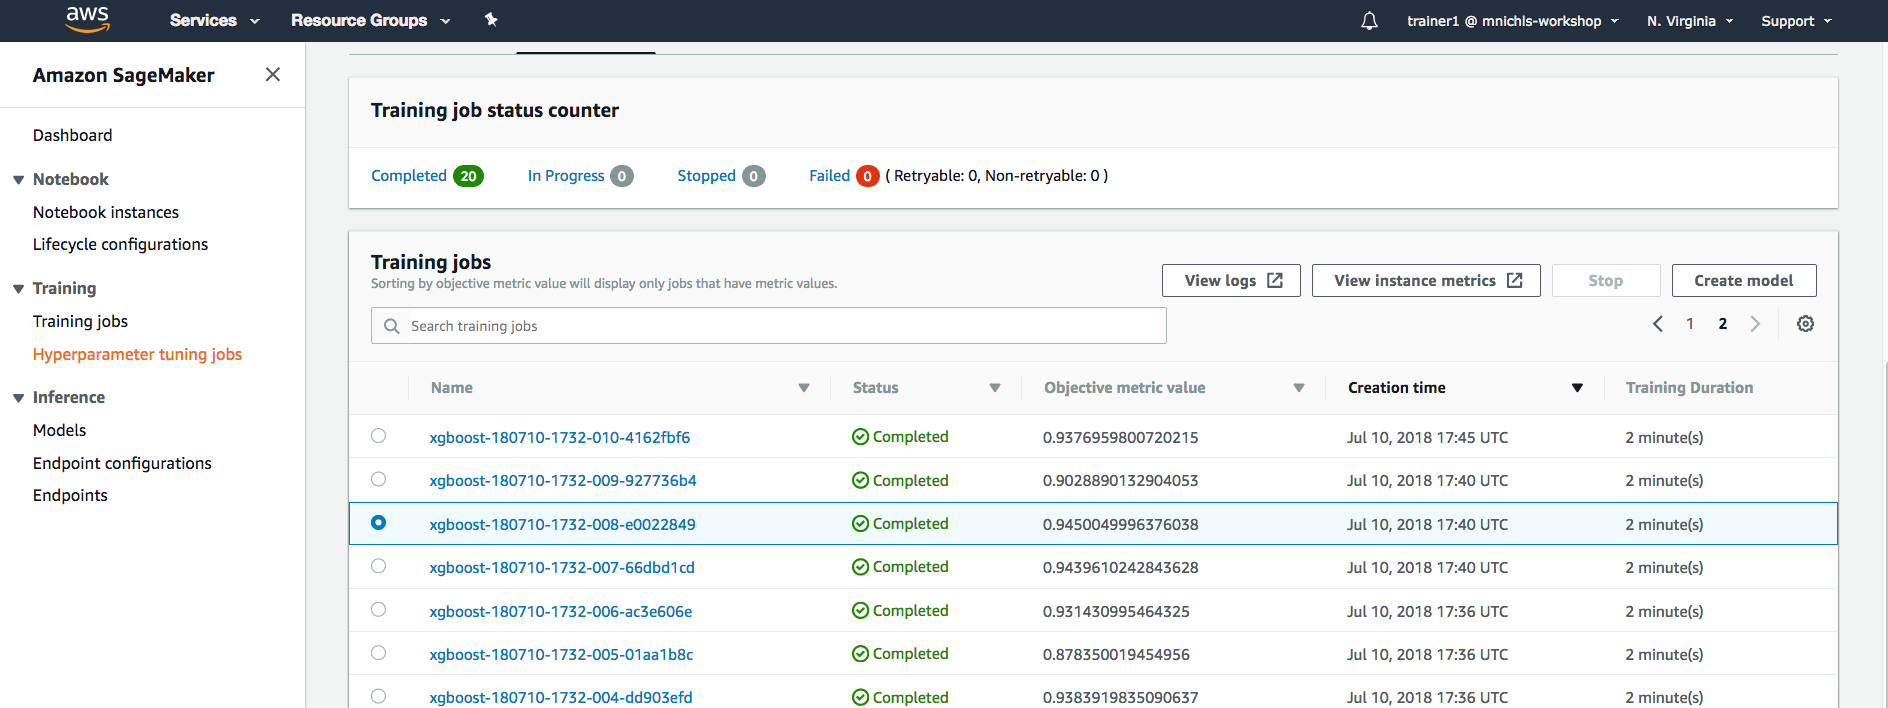


Take note of the name you give the model, you'll use that later

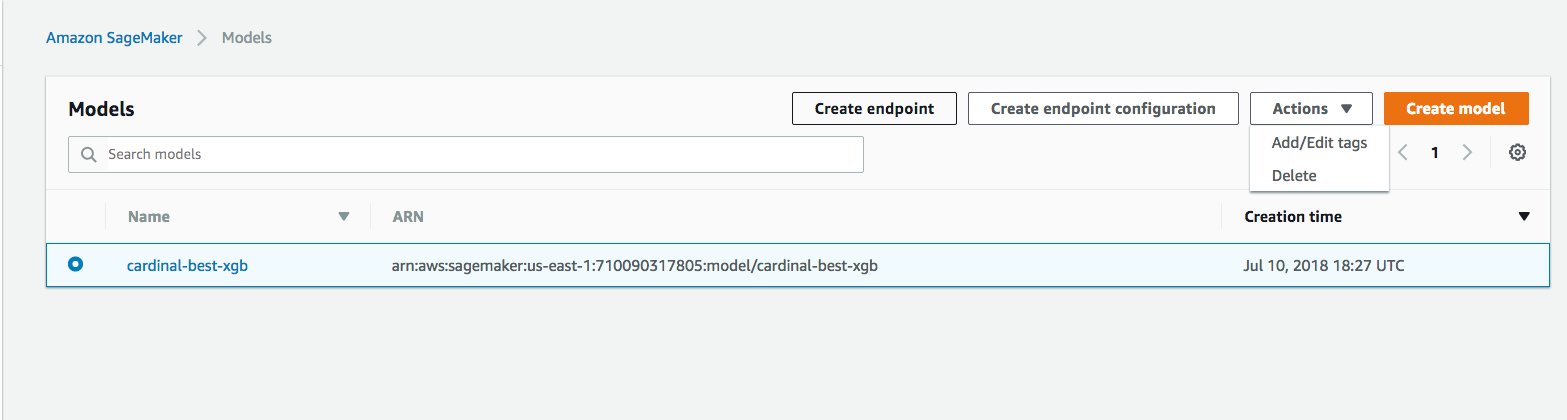

Walk through the GUI and change the name a bit, I added "-ep" at the end.

In [94]:
xgb_predictor = sagemaker.predictor.RealTimePredictor(
    endpoint = 'hw3-wherring-best-knn-ep')

In [95]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [105]:
%%time
def predict(data, rows=50):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(df_test[predictors].as_matrix())

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 158 ms


## Evaluation

### auROC
Now we'll check our area under the Receiver Operating Characteristic curve to see how confident we are in predicted versus actuals. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. This allows us to evaluate the model without selecting threshold value (at what probability and above will we classify it as an event).

In [106]:
def plotROC(actual, pred):
    fpr, tpr, thresholds = metrics.roc_curve(actual , pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
import scipy.stats as sc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as gs
from sklearn.model_selection import StratifiedKFold
import sklearn.preprocessing as st
from sklearn.pipeline import Pipeline
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
warnings.filterwarnings('ignore')
%matplotlib inline
plotROC(df_test[target].values, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [234, 0]

### F1 Scores
The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.
* Precision = TP/(TP + FP) or the % of the predicted events that are actually events
* Recall = TP/(TP + FN) or the % of the actual events the model finds

In [98]:
def get_F1Scores(actual,pred):
    F1_score =[]
    for i in np.arange(0,1.01,0.05):
        pred_class = np.where(pred >= i ,1,0)
        
        mat= confusion_matrix(actual, pred_class)
        tn,fp,fn,tp = mat[0,0],mat[0,1],mat[1,0],mat[1,1]
        #print (tn, fp,fn,tp
        precision = float(tp)/(tp+fp)
        recall = float(tp)/(tp+fn)
        #print precision, recall
        if precision !=0 and recall !=0 :
            f1score = 2*precision * recall/(precision + recall)
        else:
            f1score = 0
        perc_pred_pos = np.sum(pred_class)* 100 /(tp +fp +tn + fn) 
        #print ((tp +fp +tn + fn) )
        F1_score.append([i ,tp,fp,tn,fn,precision,recall,f1score,perc_pred_pos])
    res = pd.DataFrame(F1_score, columns = ['Threshold','True Pos','False pos',\
    'True neg' ,'False Neg','Precision','Recall','F1Score','Perc Predicted Possitve'])
    return res

get_F1Scores(df_test[target].values, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [234, 0]

### Variable Importance
Importance is calculated for a single decision tree by the amount that each attribute split
point improves the performance measure, weighted by the number of observations the node is
responsible for. The performance measure may be the purity (Gini index) used to select the
split points or another more specific error function. The feature importances are then averaged
across all of the decision trees within the model. For more technical information on how feature
importance is calculated in boosted decision trees, see Section 10.13.1 Relative Importance of
Predictor Variables of the book [The Elements of Statistical Learning: Data Mining, Inference,
and Prediction, page 367.](https://www.amazon.com/Elements-Statistical-Learning-Prediction-Statistics/dp/0387848576/ref=sr_1_2?ie=UTF8&qid=1524588001&sr=8-2&keywords=The+Elements+of+Statistical+Learning)

In [50]:
import pickle as pkl
key = '{}/output/xgboost-180710-1732-008-e0022849/output/model.tar.gz'.format(prefix)

# download the zipped file
s3.download_file(bucket, key, 'model-csv.tar.gz')

In [52]:
# change to a sub-directory so we can identify individual models once unzipped
# Used Jupyter GUI controls to move the model-csv.tar.gz to the folder below
os.chdir('./model-csv/')
!ls -all

total 48
drwxrwxr-x 2 ec2-user ec2-user  4096 Jul 10 19:19 .
drwxr-xr-x 6 ec2-user ec2-user  4096 Jul 11 20:17 ..
-rw-rw-r-- 1 ec2-user ec2-user  6562 Jul 10 19:15 model-csv.tar.gz
-rw-r--r-- 1 ec2-user ec2-user 29840 Jul 10 17:44 xgboost-model


In [53]:
# unzip the model, this is why we need the new directory, they will all unzip to xgboost-model
# this isn't a problem if you only evaluate one xgb, but that is rarely the case
!tar -xzvf model-csv.tar.gz
!ls -all

xgboost-model
total 48
drwxrwxr-x 2 ec2-user ec2-user  4096 Jul 11 20:18 .
drwxr-xr-x 6 ec2-user ec2-user  4096 Jul 11 20:17 ..
-rw-rw-r-- 1 ec2-user ec2-user  6562 Jul 10 19:15 model-csv.tar.gz
-rw-r--r-- 1 ec2-user ec2-user 29840 Jul 10 17:44 xgboost-model


In [54]:
# load the booster/model
model = pkl.load(open('xgboost-model','rb')) 

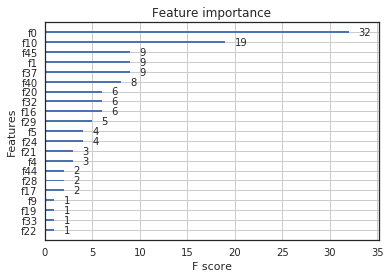

In [55]:
from xgboost import plot_importance
ax = plot_importance(model)

In [56]:
#create a dictionary mapping the numeric feature name to the text name of that feature
dict_features = dict(zip(model.feature_names, predictors))
print("Features Dictionary:\n", dict_features, "\n\n")

# get the numeric importance
dict_importance = model.get_fscore()
print("Importance Dictionary:\n", dict_importance, "\n\n")

# create dataframe
df_imp = pd.DataFrame(list(dict_features.items()), columns=['Feature_Number',
                                                            'Feature_Name'])
df_imp['Feature_Imp'] = df_imp['Feature_Number'].map(dict_importance)
df_imp.fillna(0, inplace=True)
print(df_imp)

Features Dictionary:
 {'f0': 'min_to_maxdate', 'f1': 'counts', 'f2': '% missing', 'f3': 'data gap', 'f4': 'rare variance', 'f5': 'att1_std', 'f6': 'att2_std', 'f7': 'att3_std', 'f8': 'att4_std', 'f9': 'att5_std', 'f10': 'att6_std', 'f11': 'att7_std', 'f12': 'att9_std', 'f13': 'S', 'f14': 'W', 'f15': 'Z', 'f16': 'att1_max', 'f17': 'att2_max', 'f18': 'att3_max', 'f19': 'att4_max', 'f20': 'att5_max', 'f21': 'att6_max', 'f22': 'att7_max', 'f23': 'att9_max', 'f24': 'att1_min', 'f25': 'att2_min', 'f26': 'att3_min', 'f27': 'att4_min', 'f28': 'att5_min', 'f29': 'att6_min', 'f30': 'att7_min', 'f31': 'att9_min', 'f32': 'att1_range', 'f33': 'att2_range', 'f34': 'att3_range', 'f35': 'att4_range', 'f36': 'att5_range', 'f37': 'att6_range', 'f38': 'att7_range', 'f39': 'att9_range', 'f40': 'att1_slope', 'f41': 'att2_slope', 'f42': 'att3_slope', 'f43': 'att4_slope', 'f44': 'att5_slope', 'f45': 'att6_slope', 'f46': 'att7_slope', 'f47': 'att9_slope', 'f48': 'att2nunique', 'f49': 'att3nunique', 'f50': 'at

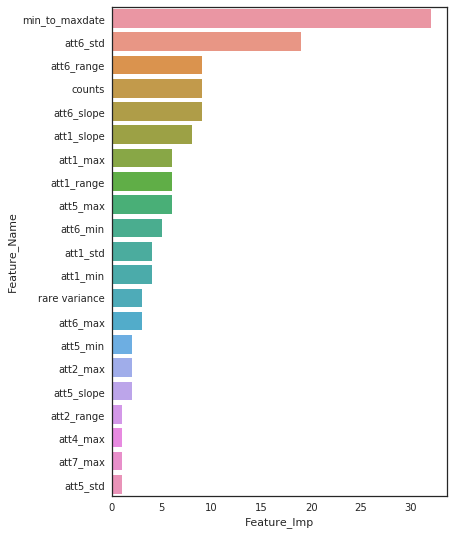

In [57]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 9))

# sort the df for desired order
df_imp = df_imp.sort_values(by=['Feature_Imp'], ascending=False)
sns.barplot(x="Feature_Imp", y="Feature_Name", data=df_imp[df_imp.Feature_Imp > 0])

## Summary
This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training, hyperparameter optimization and real-time model hosting, which could easily be applied to much larger problems. In a real-world project scenario, we would also spend more time engineering features by hand, and potentially look for additional datasets to include which contain customer information not available in our initial dataset. 

 
### (Optional) Clean-up
If you are done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)